In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os

%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17468789726517749625
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6705216225
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7581341908572111564
physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [578]:
train_x = pd.read_csv('input/train_x.csv', index_col=0, header=None)
train_y = pd.read_csv('input/train_y.csv', index_col=0)
test_x = pd.read_csv('input/test_x.csv', index_col=0, header=None)

mappping_type = {'Bird': 0, 'Airplane': 1}
train_y_bin = train_y.replace({"target": mappping_type})

d1 = [[np.array(x)] for x in train_x.values]
d = {'map': d1, 'target': train_y_bin.target}

df = pd.DataFrame(data=d)

In [580]:
train_x.shape, test_x.shape

((7200, 3072), (4800, 3072))

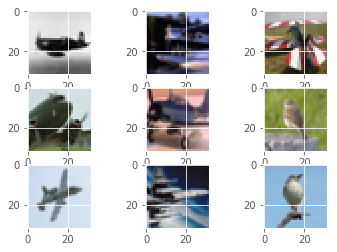

In [576]:
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_x[i])
plt.show()

In [4]:
test_x.shape

(4800, 3072)

In [5]:
import matplotlib
matplotlib.use("Agg")
 
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import os
# from keras.utils import np_utils
import gc 

import pandas as pd 
import matplotlib.pyplot as plt 
import os
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


In [323]:
EPOCHS = 100
INIT_LR = 1e-3
IMAGE_DIMS = (32 , 32 , 3)
BATCH_SIZE = 200
SIZE_DF = df.map.shape[0]

In [324]:
def make_image_gen_cat(in_df, batch_size=BATCH_SIZE):
    all_batches = in_df.sample(frac=1)
    out_map = []
    out_class = []
    size = in_df.shape[0]
    indexes = np.random.randint(0, size, size)
    while True:
        for index in indexes:
            out_map += [in_df.map.values[index][0]/255.]
            out_class += [in_df.target.values[index]]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_map = out_map.reshape(out_map.shape[0], IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])
                yield np.stack(out_map, 0), np.array(np_utils.to_categorical(out_class, num_classes=2))
                out_map = []
                out_class = []

In [325]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)
train_df.shape[0], valid_df.shape[0]

(5760, 1440)

In [523]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               horizontal_flip=True,
               rotation_range = 35, 
               width_shift_range = 0.1, 
               height_shift_range = 0.1, 
               fill_mode='nearest')

dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 15,
               width_shift_range = 0.1, 
               height_shift_range = 0.1,)


image_gen = ImageDataGenerator(**dg_args)
def create_aug_gen(in_gen):
    for in_x, in_y in in_gen:
        g_x = image_gen.flow(in_x, 
                             batch_size=in_x.shape[0])

        yield next(g_x), in_y

In [524]:
train_gen = make_image_gen_cat(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape)
print('y', train_y.shape)
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)

gc.collect()

x (200, 32, 32, 3)
y (200, 2)


483

(200, 32, 32, 3) (200, 2)
[0. 1.]
Wall time: 84.8 ms


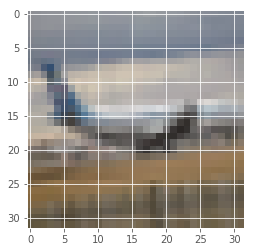

In [525]:
%%time
valid_x, valid_y = next(create_aug_gen(make_image_gen_cat(train_df)))
print(valid_x.shape, valid_y.shape)

n = 16
plt.imshow(valid_x[n,:,:])
print(valid_y[n])

### Build model 

In [526]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.utils import np_utils
import keras

In [549]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL
        model.add(Conv2D(16, (5, 5), padding="same", 
                         input_shape=(IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (5, 5), padding="same"))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (5, 5), padding="same"))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(5, 5)))
        model.add(Dropout(0.4))

#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(200))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(30))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        
        model.add(Activation(finalAct))

        # return the constructed network architecture
        return model

In [550]:
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
                            depth=IMAGE_DIMS[2], classes=2, 
                            finalAct="sigmoid")

In [551]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_421 (Conv2D)          (None, 32, 32, 16)        1216      
_________________________________________________________________
activation_525 (Activation)  (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_480 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_422 (Conv2D)          (None, 32, 32, 32)        12832     
_________________________________________________________________
activation_526 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_481 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_423 (Conv2D)          (None, 32, 32, 32)        25632     
__________

In [552]:
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, dice_coef, acc, _ = self.model.evaluate(x, y, verbose=0)
        print('\n - Testing loss: {:.4f} - dice_coef: {:.4f} - acc: {:.4f}\n'.format(loss, dice_coef, acc))

In [553]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [554]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="C:\\Users\\user\\Python_Code\\Kaggle\\Plane&Bird\\strong_weights_2.h5"
# weight_path = ''
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=20)

schedule = SGDRScheduler(min_lr=1e-5, 
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(100/50),
                         lr_decay=0.9,
                         cycle_length=10,
                         mult_factor=1.5)


callbacks_list = [checkpoint, early, schedule]

gc.collect()

901

In [555]:
from keras import metrics
from keras import backend as K

model.compile(optimizer=Adam(1e-3, decay=1e-6), 
             loss="categorical_crossentropy",
             metrics=["accuracy"])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model)

In [572]:
gen_train_cat = make_image_gen_cat(train_df, batch_size=100)
gen_valid_cat = make_image_gen_cat(valid_df, batch_size=100)

aug_gen_cat = create_aug_gen(make_image_gen_cat(train_df, batch_size=50))


net = model.fit_generator(aug_gen_cat,
                          steps_per_epoch=100,
                          epochs=100,
                          validation_data=gen_valid_cat,
                          validation_steps=20,
                          callbacks=callbacks_list,
                          workers=1, 
                          verbose=1)

Epoch 1/100
100/100 [==============================] - 5s 51ms/step - loss: 0.9811 - acc: 0.5102 - val_loss: 0.6966 - val_acc: 0.5035

Epoch 00001: val_acc did not improve from 0.92750
Epoch 2/100
100/100 [==============================] - 5s 52ms/step - loss: 0.6940 - acc: 0.5076 - val_loss: 0.6922 - val_acc: 0.5060

Epoch 00002: val_acc did not improve from 0.92750
Epoch 3/100
100/100 [==============================] - 5s 51ms/step - loss: 0.6929 - acc: 0.5156 - val_loss: 0.6903 - val_acc: 0.5125

Epoch 00003: val_acc did not improve from 0.92750
Epoch 4/100
100/100 [==============================] - 6s 56ms/step - loss: 0.6929 - acc: 0.5132 - val_loss: 0.6901 - val_acc: 0.5075

Epoch 00004: val_acc did not improve from 0.92750
Epoch 5/100
100/100 [==============================] - 6s 55ms/step - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6903 - val_acc: 0.5140

Epoch 00005: val_acc did not improve from 0.92750
Epoch 6/100
100/100 [==============================] - 5s 49ms/step - loss:

KeyboardInterrupt: 

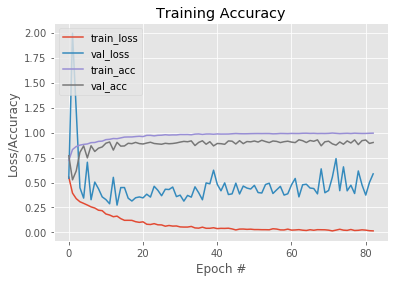

In [558]:

# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(net.epoch)
plt.plot(np.arange(0, N), net.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), net.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), net.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), net.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

### Download the best weights

In [559]:
model.load_weights(weight_path)

In [571]:
gen_valid_cat = make_image_gen_cat(valid_df, batch_size=1000)
model2_test_acc=model.evaluate_generator(gen_valid_cat, steps=100, verbose=1)
model2_test_acc

100/100 [==============================] - 16s 156ms/step


[0.36629360914230347, 0.9223599982261658]

### Make submit 

In [563]:
test_x = pd.read_csv('input/test_x.csv', index_col=0, header=None)
test_d1 = [[np.array(x)] for x in test_x.values]
test_d1 = {'map': test_d1}
test = pd.DataFrame(data=test_d1)

In [564]:
out_map = []
out_class = []
for index, row in test.iterrows():
    out_map += [pd.Series(row).values[0][0]]

out_map = np.array(out_map)
out_map = out_map.reshape(out_map.shape[0], IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])
out_map = np.stack(out_map, 0)

In [565]:
%%time
y_test_pred = model.predict(out_map)

print(y_test_pred.shape)

(4800, 2)
Wall time: 8.51 s


In [566]:
%%time
y_test_pred = model.predict(out_map)

print(y_test_pred.shape)

df = np.array([[i, x.argmax()] for i, x in enumerate(y_test_pred)])
sample = pd.DataFrame(df, columns=['id', 'target'])

mappping_type_inv = {0: 'Bird', 1: 'Airplane'}
sample = sample.replace({'target': mappping_type_inv})

sample.to_csv('output/submit_12.csv', index=False)

(4800, 2)
Wall time: 1.58 s


In [567]:
sample.head()

,id,target
0,0,Airplane
1,1,Airplane
2,2,Airplane
3,3,Airplane
4,4,Airplane


In [569]:
sample.to_csv('output/submit_circle1.csv', index=False)